# Анализ результатов A/B теста интернет-магазина

**Цель проекта:** Проверить гипотезы для увеличения выручки интернет-магазина.

**Задачи проекта:**
* Приоритизировать гипотезы
* Сделать анализ результатов A/B теста
* Принять решение об остановке или продолжении A/B теста

**Содержание:**
* [1. Приоритизация гипотез](#1)
* [2  Анализ A/B-теста](#2)
* [2.1  Предобработка данных](#2.1)
* [2.2  Расчёт кумулятивной выручки по группам](#2.2)
* [2.3 Расчёт кумулятивного среднего чека по группам](#2.3)
* [2.4 Расчёт относительного изменения кумулятивного среднего чека группы "B" к группе "A"](#2.4)
* [2.5 Расчёт кумулятивной конверсии по группам](#2.5)
* [2.6 Расчёт относительного изменения кумулятивной конверсии группы "B" к группе "A"](#2.6)
* [2.7 Точечный график количества заказов по пользователям](#2.7)
* [2.8 Выбор границы для определения аномальных пользователей](#2.8)
* [2.9 Точечный график стоимостей заказов](#2.9)
* [2.10 Выбор границы для определения аномальных заказов](#2.10)
* [2.11 Расчёт статистической значимости различий в среднем количестве заказов  между группами по «сырым» данным](#2.11)
* [2.12 Расчёт статистической значимости различий в среднем чеке заказа между группами по «сырым» данным](#2.12)
* [2.13 Расчёт статистической значимости различий в среднем количестве заказов между группами по «очищенным» данным](#2.13)
* [2.14 Расчёт статистической значимости различий в среднем чеке заказа между группами по «очищенным» данным](#2.14)
* [3. Общий вывод](#3)

<a id="1"></a>
## Приоритизация гипотез

Импортируем необходимые бибилотеки для проекта.

In [1]:
import pandas as pd
import scipy.stats as stats
import numpy as np
import plotly.express as px

Откроем датасет с гипотезами.

In [2]:
data_hypothesis = pd.read_csv ('C:/Documents/Yandex Practicum/Projects/7. Анализ результатов AB теста интернет-магазина/data_hypothesis.csv')
data_hypothesis.head (10)

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине,...",3,2,2,3
6,Показать на главной странице баннеры с актуаль...,5,3,8,3
7,Добавить форму подписки на все основные страни...,10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день...",1,9,9,5


Датасет содержит описание гипотез и значения параметров для их приоритезации. Воспользуемся методами ICE и RICE для приоритизации гипотез.

In [3]:
data_hypothesis ['ICE'] = round ((data_hypothesis ['Impact'] * data_hypothesis ['Confidence']) / data_hypothesis ['Efforts'], 1)
data_hypothesis ['RICE'] = round ((data_hypothesis ['Reach'] * data_hypothesis ['Impact'] * data_hypothesis ['Confidence']) / data_hypothesis ['Efforts'], 1)

for i in ['ICE', 'RICE']:
    display (data_hypothesis [['Hypothesis', i]].sort_values (by = i, ascending = False).head (10))

,Hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день...",16.2
0,"Добавить два новых канала привлечения трафика,...",13.3
7,Добавить форму подписки на все основные страни...,11.2
6,Показать на главной странице баннеры с актуаль...,8.0
2,Добавить блоки рекомендаций товаров на сайт ин...,7.0
1,"Запустить собственную службу доставки, что сок...",2.0
5,"Добавить страницу отзывов клиентов о магазине,...",1.3
3,"Изменить структура категорий, что увеличит кон...",1.1
4,"Изменить цвет фона главной страницы, чтобы уве...",1.0


,Hypothesis,RICE
7,Добавить форму подписки на все основные страни...,112.0
2,Добавить блоки рекомендаций товаров на сайт ин...,56.0
0,"Добавить два новых канала привлечения трафика,...",40.0
6,Показать на главной странице баннеры с актуаль...,40.0
8,"Запустить акцию, дающую скидку на товар в день...",16.2
3,"Изменить структура категорий, что увеличит кон...",9.0
1,"Запустить собственную службу доставки, что сок...",4.0
5,"Добавить страницу отзывов клиентов о магазине,...",4.0
4,"Изменить цвет фона главной страницы, чтобы уве...",3.0


Метод ICE позволил выявить гипотезы под номерами 8, 0, 7 как наиболее приоритетные. Метод RICE также выделил гипотезы под номерами 7 и 0, однако, гипотеза 8 оказалась в середине списка. Это произошло из-за того, что метод RISE учитывает охват пользователей, который при проверке гипотезы 8, будет совсем незначительным, в то время, как охват пользователей при проверке гипотезы №2 оценивается в 8 баллов из 10 возможных. Поэтому в ТОП-3 приоритетных гипотез методом RISE вошла гипотеза №2, а не №8.

<a id="2"></a>
## Анализ A/B-теста
<a id="2.1"></a>
### Предобработка данных

Рассмотрим результаты A/B теста в двух датасетах.

In [4]:
data_orders = pd.read_csv ('C:/Documents/Yandex Practicum/Projects/7. Анализ результатов AB теста интернет-магазина/data_orders.csv')
data_visitors = pd.read_csv ('C:/Documents/Yandex Practicum/Projects/7. Анализ результатов AB теста интернет-магазина/data_visitors.csv')

for i in [data_orders, data_visitors]:
    display (i.info ())
    display (i.head ())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


None

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


None

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


Датасет `data_orders` содержит информацию о заказах (id транзакции, id клиента, дата, выручка, группа тестирования). Датасет `data_visitors` - информацию о количестве просмотров страницы (дата, группа тестирования, количество человек). Изменим тип данных в колонке с датой в обеих таблицах.

In [5]:
for i in [data_orders, data_visitors]:
    i ['date'] = pd.to_datetime (i ['date'])

Изменим названия столбцов в `data_orders`.

In [6]:
data_orders = data_orders.rename ({'transactionId': 'transaction_id', 'visitorId': 'visitor_id'}, axis = 1)

Проверим датасеты на пропуски в данных и дубликаты.

In [7]:
for i in [data_orders, data_visitors]:
    print ('\nПропуски в данных:\n', i.isna().sum())
    print ('Количество дубликатов:', i.duplicated().sum())


Пропуски в данных:
 transaction_id    0
visitor_id        0
date              0
revenue           0
group             0
dtype: int64
Количество дубликатов: 0

Пропуски в данных:
 date        0
group       0
visitors    0
dtype: int64
Количество дубликатов: 0


Пропуски и дубликаты отсутствуют. Проверим соответствие контрольных групп в обоих датасетах.

In [8]:
for i in [data_orders, data_visitors]:
    print (i ['group'].unique())

['B' 'A']
['A' 'B']


Контрольные группы записаны корректно в обоих таблицах. Проверим также колонки с числовыми значениями.

In [9]:
data_orders ['revenue'].describe().apply ('{0:.1f}'.format)

count       1197.0
mean        8348.0
std        39191.1
min           50.0
25%         1220.0
50%         2978.0
75%         8290.0
max      1294500.0
Name: revenue, dtype: object

В колонке с выручкой очень большой разброс данных: от 50 до 1294500 руб. Это могут быть отдельные оптовые покупки, сильно выбивающиеся из общей массы.

In [10]:
data_visitors ['visitors'].describe().apply ('{0:.1f}'.format)

count     62.0
mean     607.3
std      114.4
min      361.0
25%      534.0
50%      624.5
75%      710.5
max      770.0
Name: visitors, dtype: object

В колонке с количеством посетителей нет сильно выбивающихся значений. Минимальное кол-во посетителей - 361, максимальное - 770. Проверим также соответствие минимальной и максимальной даты проведения A/B теста в обоих датасетах.

In [11]:
if data_orders ['date'].min() == data_visitors ['date'].min() and data_orders ['date'].max() == data_visitors ['date'].max():
    print ('Диапозон проведения A\B теста во времени совпадает в обоих датасетах.')
else:
    print ('Диапозон проведения A\B теста во времени у двух датасетов НЕ совпадает. Следует проверить различие в данных.')

Диапозон проведения A\B теста во времени совпадает в обоих датасетах.


Проверим, сколько пользователей в каждой группе.

In [12]:
group_visitors = data_orders.groupby ('group')['visitor_id'].unique()

for i, j in zip (group_visitors, ['A', 'B']):
    print (j, len (i))

A 503
B 586


Уникальных пользователей в группе "B" больше на 83 пользователя. Проверим, не попадают ли какие-то пользователи в обе группы.

In [13]:
any (i in group_visitors ['A'] for i in group_visitors ['B'])

True

Функция `any` показала наличие одних и тех же пользователей в обеих группах. Найдём количество таких пользователей по id.

In [14]:
repeat_visitors = list (filter (lambda i: i in group_visitors ['A'], group_visitors ['B']))
len (repeat_visitors)

58

58 уникальных пользователей попали в обе контрольные группы. При проведении A\B теста такого не должно быть, возможно, это ошибка. Для дальнейшего исследования необходимо избавиться от данных по этим пользователям в обеих группах.

In [15]:
data_orders = data_orders.query ('visitor_id != @repeat_visitors')

Данные результатов A\B теста пребобработаны и готовы к анализу.

<a id="2.2"></a>
### Расчёт кумулятивной выручки по группам

Создадим массив уникальных пар значений дат и групп теста.

In [16]:
dates_groups = data_orders [['date','group']].drop_duplicates()
dates_groups.head()

,date,group
0,2019-08-15,B
7,2019-08-15,A
45,2019-08-16,A
47,2019-08-16,B
55,2019-08-01,A


Получим агрегированные кумулятивные по дням данные о заказах.

In [17]:
data_orders_agg = dates_groups.apply (lambda x: data_orders [np.logical_and (data_orders ['date'] <= x ['date'],
                                                                             data_orders ['group'] == x ['group'])] \
                               .agg ({'date' : 'max',
                                      'group' : 'max',
                                      'visitor_id' : 'nunique',
                                      'revenue' : 'sum'}), axis = 1) \
                               .sort_values (by = ['date','group']) \
                               .rename ({'visitor_id': 'orders'}, axis = 1)
data_orders_agg.head (10)

,date,group,orders,revenue
55,2019-08-01,A,19,142779
66,2019-08-01,B,17,59758
175,2019-08-02,A,36,234381
173,2019-08-02,B,39,221801
291,2019-08-03,A,60,346854
383,2019-08-03,B,53,288850
499,2019-08-04,A,71,388030
498,2019-08-04,B,66,385740
719,2019-08-05,A,92,474413
699,2019-08-05,B,87,475648


Построим график кумулятивной выручки.

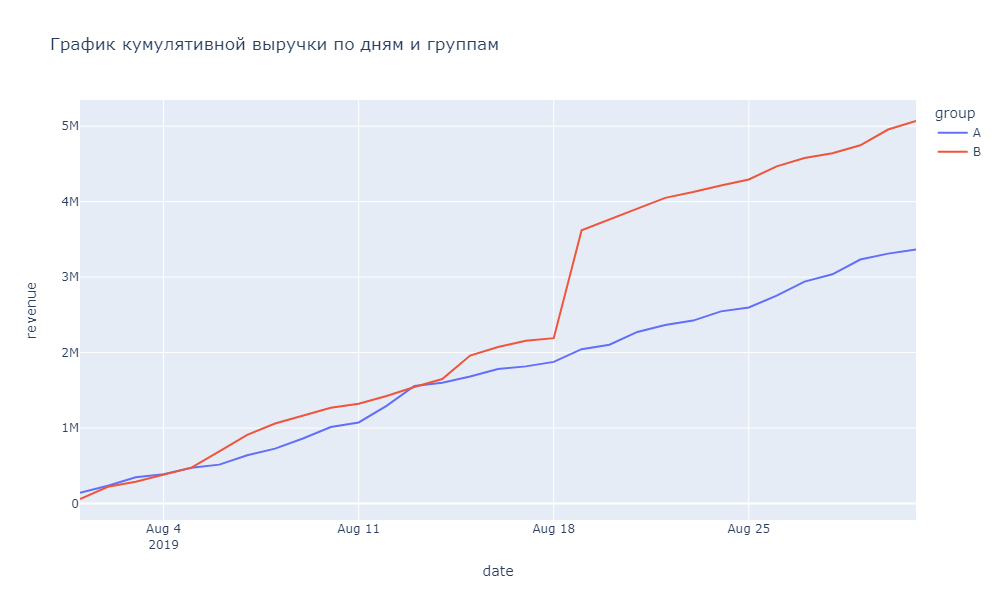

In [18]:
def fig_line (data, x, y, group, title):
    fig = px.line (data,
                   x = x,
                   y = y,
                   color = group,
                   title = title,
                   height = 600,
                   width = 1000)
    fig.show ('png')
    
fig_line (data_orders_agg, 'date', 'revenue', 'group', 'График кумулятивной выручки по дням и группам')

**Вывод**: Судя по графику, выручка группы "B" всё время была стабильно выше, а после 18 августа ещё сильнее оторвалась по динамике от группы "А". Причиной такого отрыва могут стать выбросы данных - особо крупные чеки в определённый день, например, от оптового клиента или от одной крупной покупки.

<a id="2.3"></a>
### Расчёт кумулятивного среднего чека по группам

Добавим в таблицу с агрегированными значениями новый стобец - кумулятивный средний чек, разделив кумулятивные выручку на количество заказов по группам за каждый день.

In [19]:
data_orders_agg ['average'] = round (data_orders_agg ['revenue'] / data_orders_agg ['orders'], 2)
data_orders_agg.head()

,date,group,orders,revenue,average
55,2019-08-01,A,19,142779,7514.68
66,2019-08-01,B,17,59758,3515.18
175,2019-08-02,A,36,234381,6510.58
173,2019-08-02,B,39,221801,5687.21
291,2019-08-03,A,60,346854,5780.90


Построим график кумулятивного среднего чека.

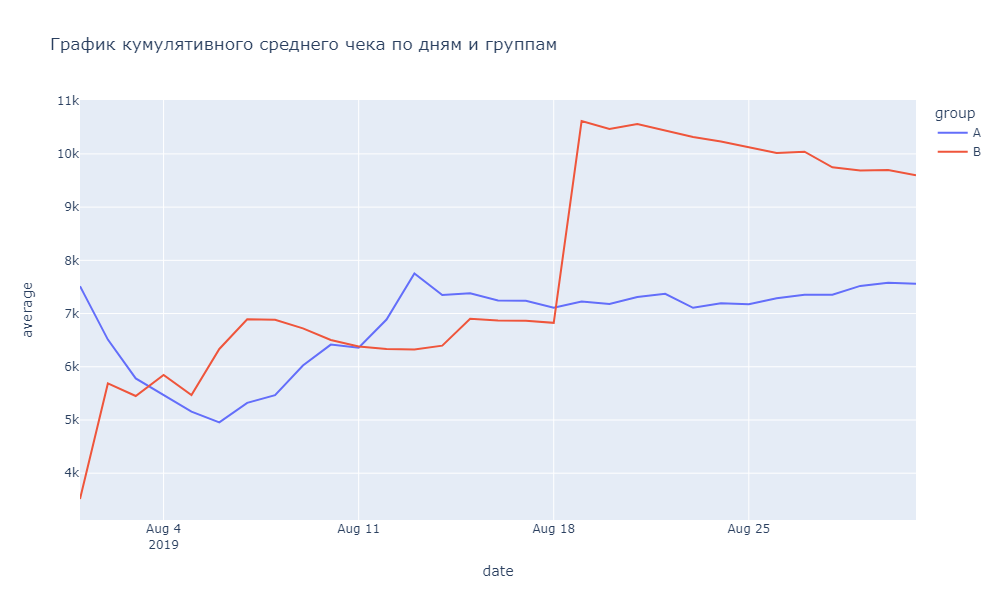

In [20]:
fig_line (data_orders_agg, 'date', 'average', 'group', 'График кумулятивного среднего чека по дням и группам')

**Вывод:** График среднего чека также показывает сильное изменение в значениях группы "B" от 18-го августа. Это подтверждает наличие крупной покупки, выбивающейся из общей массы в этот день. Однако, также можно заметить снижение показателя среднего чека у группы "B" после 18-го августа по отношению к постепенно растущим значениям у группы "A" в тот же период.

<a id="2.4"></a>
### Расчёт относительного изменения кумулятивного среднего чека группы "B" к группе "A"

Сначала разделим, а затем соединим две таблицы с показателями двух групп. Добавим колонку `relative_average` с расчётом относительного изменения среднего чека.

In [21]:
data_orders_agg_A = data_orders_agg.query ('group == "A"')
data_orders_agg_B = data_orders_agg.query ('group == "B"')
data_orders_agg_merge = data_orders_agg_A.merge (data_orders_agg_B, on = 'date', suffixes = ['_a', '_b'])
data_orders_agg_merge ['relative_average'] = (data_orders_agg_merge ['average_b'] / data_orders_agg_merge ['average_a']) - 1
data_orders_agg_merge.head()

,date,group_a,orders_a,revenue_a,average_a,group_b,orders_b,revenue_b,average_b,relative_average
0,2019-08-01,A,19,142779,7514.68,B,17,59758,3515.18,-0.532225
1,2019-08-02,A,36,234381,6510.58,B,39,221801,5687.21,-0.126466
2,2019-08-03,A,60,346854,5780.90,B,53,288850,5450.00,-0.057240
3,2019-08-04,A,71,388030,5465.21,B,66,385740,5844.55,0.069410
4,2019-08-05,A,92,474413,5156.66,B,87,475648,5467.22,0.060225


Построим график по значениям колонки `relative_average`.

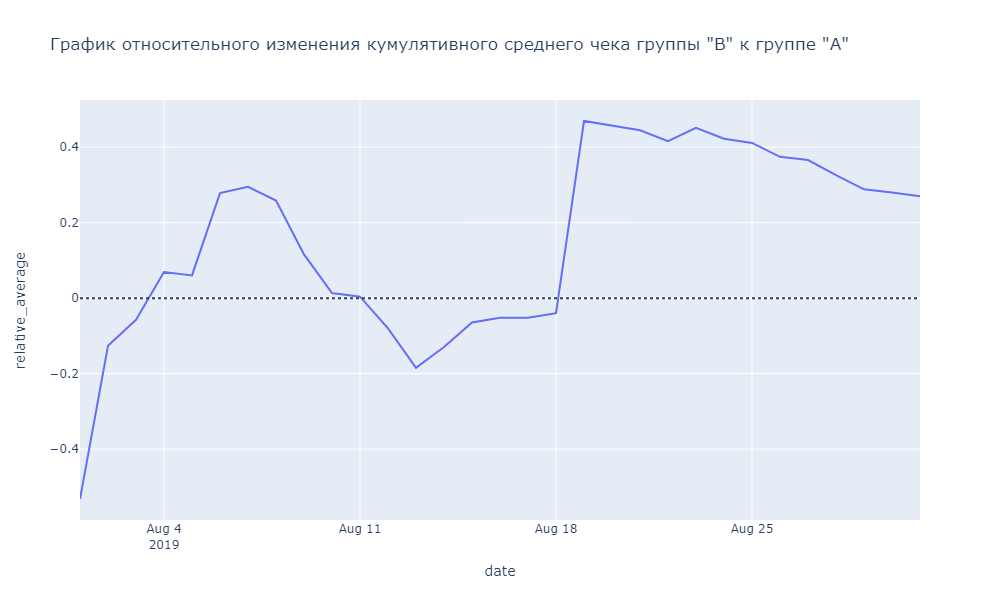

In [22]:
def fig_line_average (data, x, y, title):
    fig = px.line (data,
                   x = x,
                   y = y,
                   title = title,
                   height = 600,
                   width = 1000)
    fig.add_hline (y = 0, line_dash = 'dot')
    fig.show ('png')
    
fig_line_average (data_orders_agg_merge, 'date', 'relative_average', 'График относительного изменения кумулятивного среднего чека группы "B" к группе "A"')

**Вывод:** Группа "B" имела худшие показатели только в самом начале теста, а также в период с 11 по 16 августа. В остальные даты данная группа имела более высокие показатели по сравнению с группой "A". Однако, график относительного изменения также подверждает выводы по предыдущему графику - начиная с 19 августа отношение среднего чека второй группы к первой постепенно снижается.

<a id="2.5"></a>
### Расчёт кумулятивной конверсии по группам

Аналогичным образом, как и для заказов, посчитаем кумулятивное значение пользователей по группам и дням.

In [23]:
data_visitors.head(10)

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756
5,2019-08-06,A,667
6,2019-08-07,A,644
7,2019-08-08,A,610
8,2019-08-09,A,617
9,2019-08-10,A,406


In [24]:
data_visitors_agg = dates_groups.apply (lambda x: data_visitors [np.logical_and (data_visitors ['date'] <= x ['date'],
                                                                                 data_visitors ['group'] == x ['group'])] \
                                .agg ({'date' : 'max',
                                       'group' : 'max',
                                       'visitors' : 'sum'}), axis = 1) \
                                .sort_values (by = ['date', 'group'])
data_visitors_agg.head()

,date,group,visitors
55,2019-08-01,A,719
66,2019-08-01,B,713
175,2019-08-02,A,1338
173,2019-08-02,B,1294
291,2019-08-03,A,1845


Соединим таблицы `data_orders_agg` и `data_visitors_agg` в одну. Добавим колонку с расчётом кумулятивной конверсии.

In [25]:
data_orders_and_visitors_agg = data_orders_agg.merge (data_visitors_agg, on = ['date', 'group'])
data_orders_and_visitors_agg ['conversion'] = data_orders_and_visitors_agg ['orders'] / data_orders_and_visitors_agg ['visitors']
data_orders_and_visitors_agg.head()

,date,group,orders,revenue,average,visitors,conversion
0,2019-08-01,A,19,142779,7514.68,719,0.026426
1,2019-08-01,B,17,59758,3515.18,713,0.023843
2,2019-08-02,A,36,234381,6510.58,1338,0.026906
3,2019-08-02,B,39,221801,5687.21,1294,0.030139
4,2019-08-03,A,60,346854,5780.90,1845,0.032520


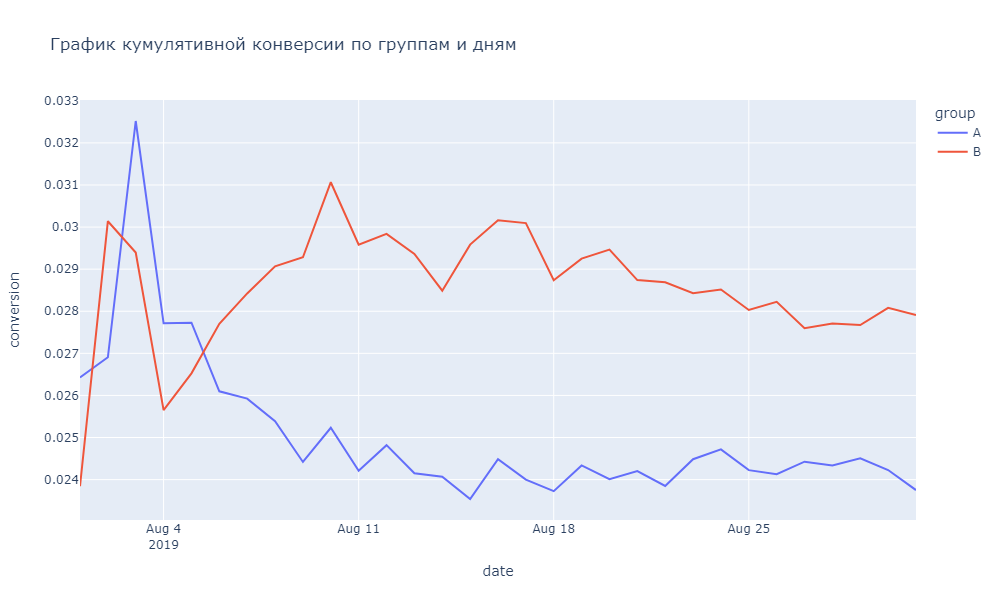

In [26]:
fig_line (data_orders_and_visitors_agg, 'date', 'conversion', 'group', 'График кумулятивной конверсии по группам и дням')

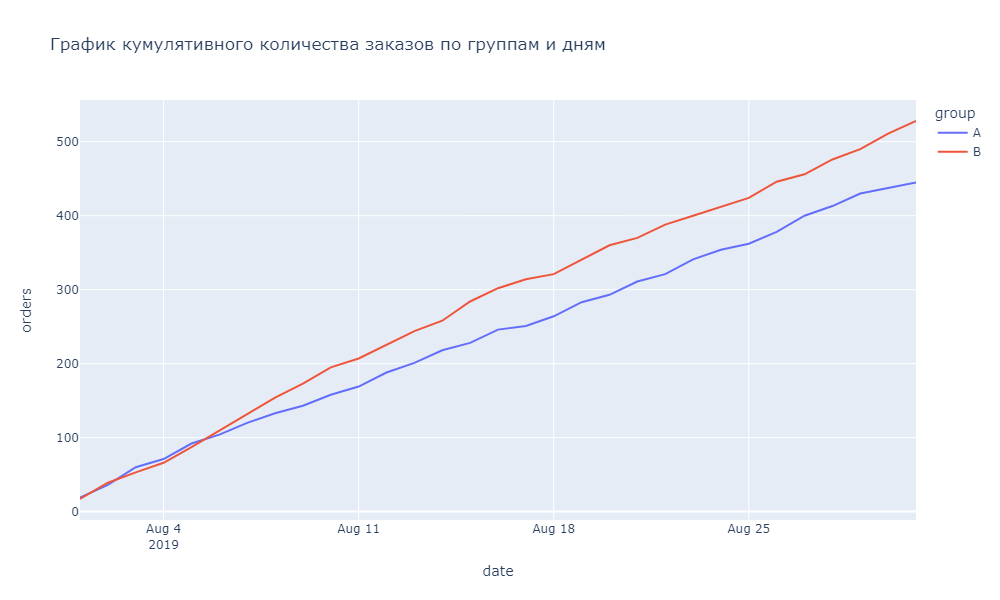

In [27]:
fig_line (data_orders_and_visitors_agg, 'date', 'orders', 'group', 'График кумулятивного количества заказов по группам и дням')

**Вывод:** В период с 5 по 10 августа конверсия групп практически равномерно удалялась друг от друга, однако, начиная с 11 августа конверсия группы "B" постепенно начала снижаться, достигнув значения в 31%, в то время как конверсия группы "A" выровнялась и колебалась в диапазоне от 26% до 28% в течение всего A\B теста. Среднее количество заказов у группы "B" стабильно выше, чем у группы "A".

<a id="2.6"></a>
### Расчёт относительного изменения кумулятивной конверсии группы "B" к группе "A"

Рассчитаем относительную конверсию по аналогии с относительной средней выручкой.

In [28]:
data_orders_and_visitors_agg_A = data_orders_and_visitors_agg.query ('group == "A"')
data_orders_and_visitors_agg_B = data_orders_and_visitors_agg.query ('group == "B"')
data_orders_and_visitors_agg_merge = data_orders_and_visitors_agg_A.merge (data_orders_and_visitors_agg_B, on = 'date', suffixes = ['_a', '_b'])
data_orders_and_visitors_agg_merge ['relative_conversion'] = (data_orders_and_visitors_agg_merge ['conversion_b'] / data_orders_and_visitors_agg_merge ['conversion_a']) - 1
data_orders_and_visitors_agg_merge ['relative_orders'] = (data_orders_and_visitors_agg_merge ['orders_b'] / data_orders_and_visitors_agg_merge ['orders_a']) - 1
data_orders_and_visitors_agg_merge.head()

,date,group_a,orders_a,revenue_a,average_a,visitors_a,conversion_a,group_b,orders_b,revenue_b,average_b,visitors_b,conversion_b,relative_conversion,relative_orders
0,2019-08-01,A,19,142779,7514.68,719,0.026426,B,17,59758,3515.18,713,0.023843,-0.097734,-0.105263
1,2019-08-02,A,36,234381,6510.58,1338,0.026906,B,39,221801,5687.21,1294,0.030139,0.120170,0.083333
2,2019-08-03,A,60,346854,5780.90,1845,0.032520,B,53,288850,5450.00,1803,0.029395,-0.096090,-0.116667
3,2019-08-04,A,71,388030,5465.21,2562,0.027713,B,66,385740,5844.55,2573,0.025651,-0.074397,-0.070423
4,2019-08-05,A,92,474413,5156.66,3318,0.027728,B,87,475648,5467.22,3280,0.026524,-0.043392,-0.054348


Построим графики.

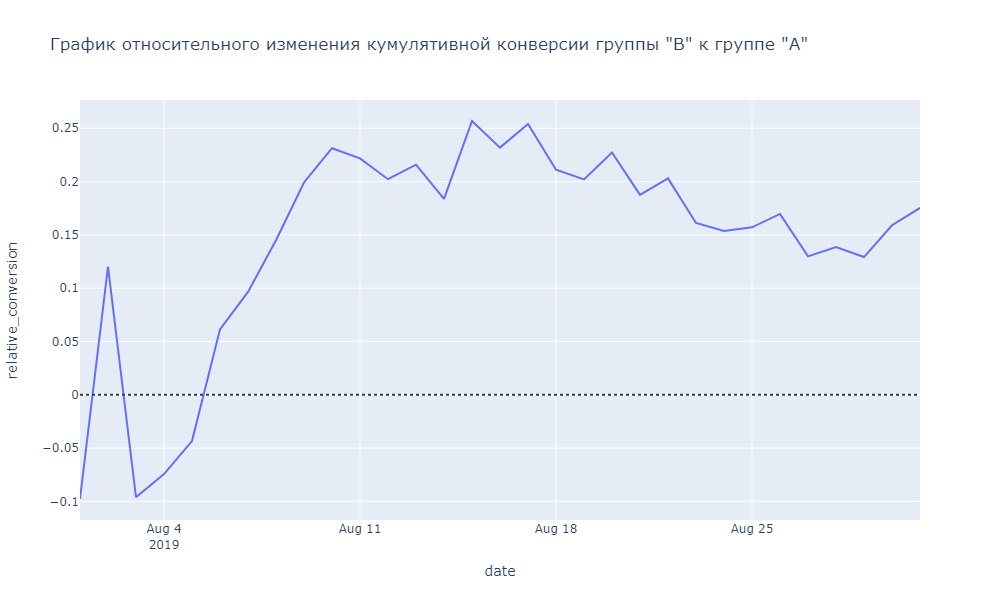

In [29]:
fig_line_average (data_orders_and_visitors_agg_merge, 'date', 'relative_conversion', 'График относительного изменения кумулятивной конверсии группы "B" к группе "A"')

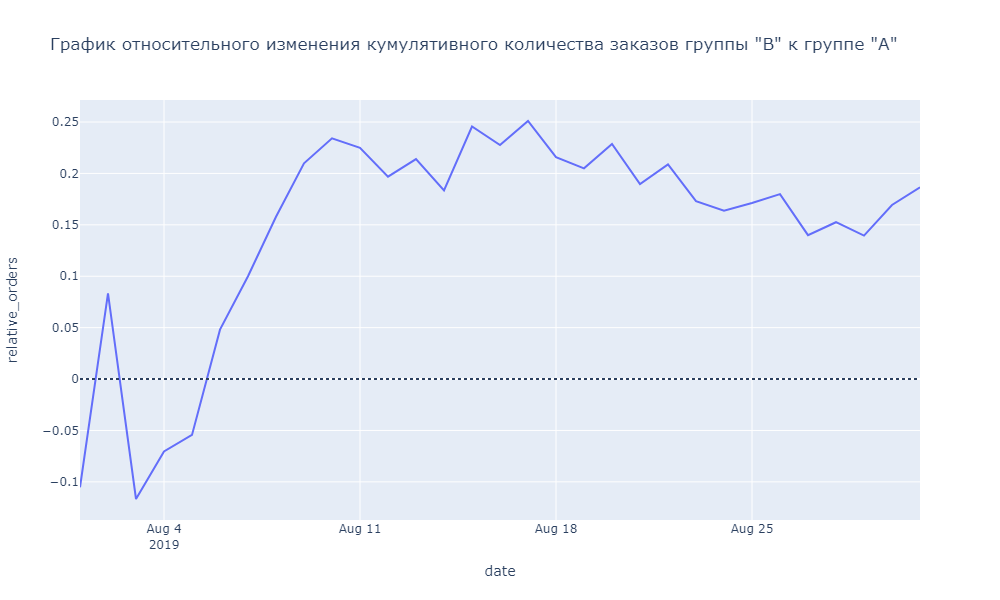

In [30]:
fig_line_average (data_orders_and_visitors_agg_merge, 'date', 'relative_orders', 'График относительного изменения кумулятивного количества заказов группы "B" к группе "A"')

**Вывод:** Графики динамики конверсии и количества заказов идентичны. Судя по графику, первую половину проведения теста конверсия группы "B" стремительно росла по отношению к конверсии группы "A", однако, после 17 августа начала постепенно снижаться. В последние три дня проведения теста снова появилась положительная динамика. В целом, по динамике относительных значений конверсии сложно сделать выводы об успешности той или иной группы. Следует проверить аномалии в значениях.

<a id="2.7"></a>
### Точечный график количества заказов по пользователям

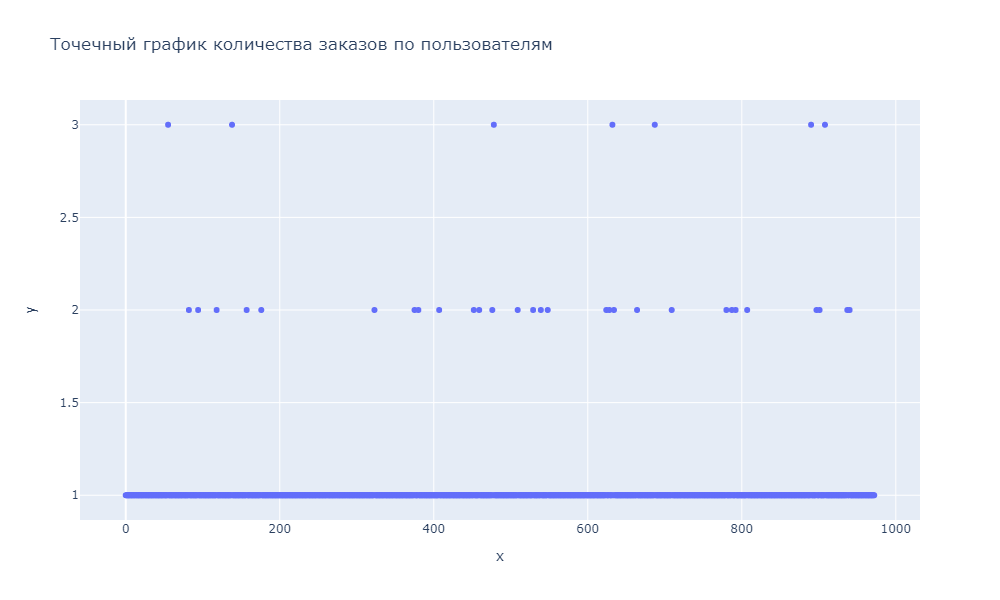

In [31]:
data_order_by_users = data_orders.groupby ('visitor_id', as_index = False) \
                                 .agg ({'transaction_id': 'nunique'})

x_values = pd.Series (range (0, len (data_order_by_users)))
fig = px.scatter (x = x_values,
                  y = data_order_by_users ['transaction_id'],
                  title = 'Точечный график количества заказов по пользователям',
                  height = 600,
                  width = 1000)
fig.show ('png')

**Вывод:** В основном на одного пользователя приходится по одному заказу, однако, есть довольно много пользователей у которых по 2-3 заказа. Совсем редкие значения - от 4 до 11 заказов. Чтобы определить, какое количество заказов считать выбросами, нужно рассчитать выборочные перцентили количества заказов на одного пользователя.

<a id="2.8"></a>
### Выбор границы для определения аномальных пользователей

In [32]:
print (np.percentile (data_order_by_users ['transaction_id'], [95, 99]))

[1. 2.]


Не более 5% пользователей оформляли больше, чем 2 заказа, и не более 1% пользователей - более 4 заказов. За верхнюю границу числа заказов на одного пользователя примем значение в 2 заказа. Пользователей, оформивших 3 и более заказов, следует отсеять для даьнейшего анализа.

<a id="2.9"></a>
### Точечный график стоимостей заказов

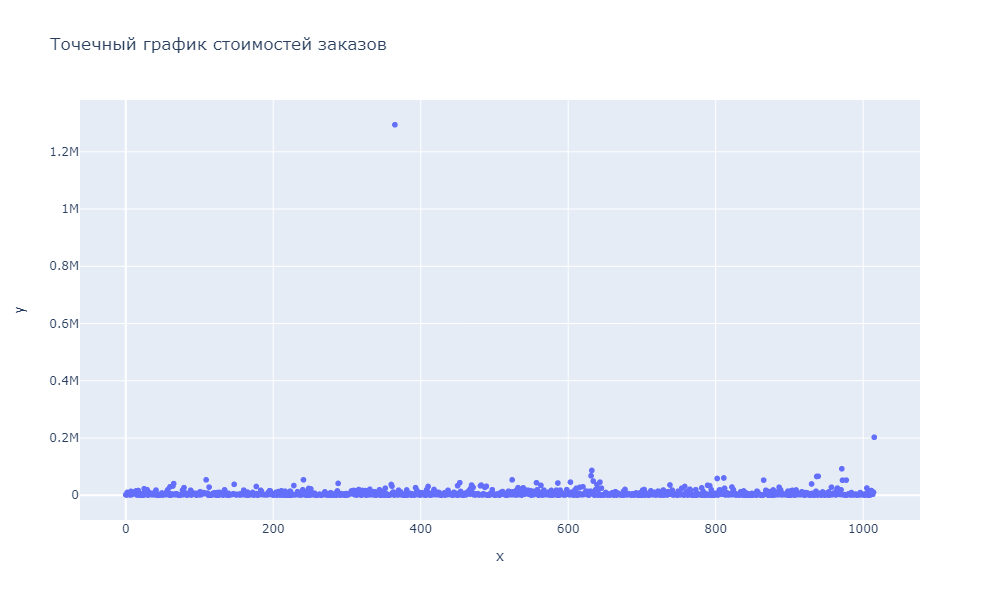

In [33]:
x_values = pd.Series (range (0, len (data_orders)))
fig = px.scatter (x = x_values,
                  y = data_orders ['revenue'],
                  title = 'Точечный график стоимостей заказов',
                  height = 600,
                  width = 1000)
fig.show ('png')

**Вывод:** Один заказ, стоимостью почти 1.3 миллиона рублей сильно искажает результаты исследования. От такого значения точно следует избавиться, однако, стоит проверить перцентили стоимости заказов для наиболее корректного отсечения выборосов.

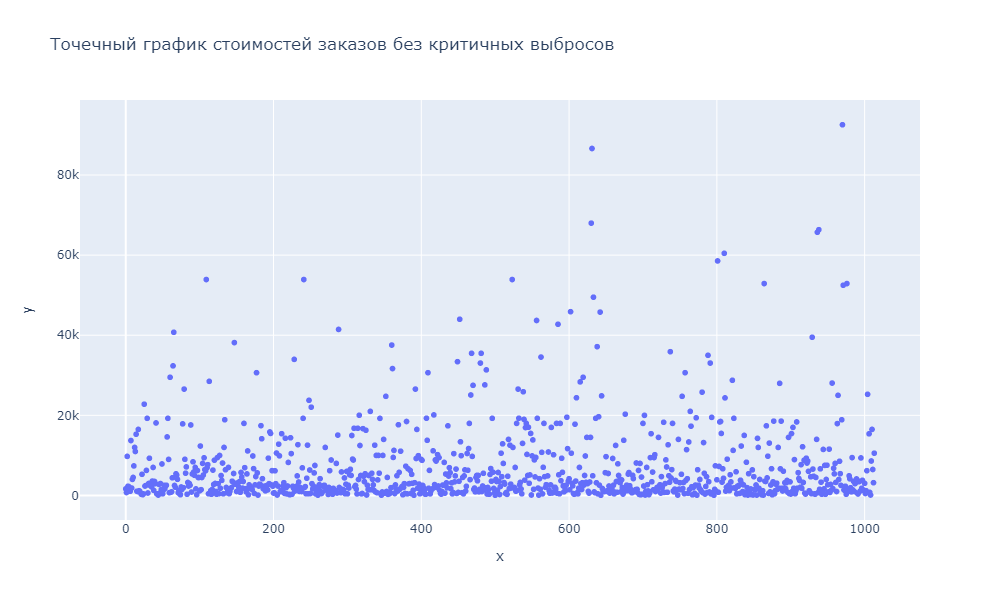

In [34]:
data_orders_no_emissions = data_orders.query ('revenue < 200000')
x_values = pd.Series (range (0, len (data_orders_no_emissions)))
fig = px.scatter (x = x_values,
                  y = data_orders_no_emissions ['revenue'],
                  title = 'Точечный график стоимостей заказов без критичных выбросов',
                  height = 600,
                  width = 1000)
fig.show ('png')

**Вывод:** Значения распределены равномерно. Чем выше стоимость заказа, тем реже встречаются значения. Основная масса заказов находится в пределах стоимости до 20 тыс. руб.

<a id="2.10"></a>
### Выбор границы для определения аномальных заказов

In [35]:
print (np.percentile (data_orders ['revenue'], [95, 99]))

[26785. 53904.]


**Вывод:** Не более 5% заказов имеют стоимость выше 28 тысяч рублей, и не более 1% заказов - выше 58233 руб. Возьмём границу в 28 тысяч рублей, выше которой все значения будем считать аномальными.

<a id="2.11"></a>
### Расчёт статистической значимости различий в среднем количестве заказов  между группами по «сырым» данным

Создадим переменные `orders_by_users_a` и `orders_by_users_b`, в которых будут указаны пользователи, имеющие хотя бы один заказ и число заказов у каждого из пользователей.

In [36]:
orders_by_users_a = data_orders.query ('group == "A"') \
                               .groupby ('visitor_id', as_index = False) \
                               .agg ({'transaction_id': 'nunique'})

orders_by_users_b = data_orders.query ('group == "B"') \
                               .groupby ('visitor_id', as_index = False) \
                               .agg ({'transaction_id': 'nunique'})

for i in [orders_by_users_a, orders_by_users_b]:
     i.columns = ['user_id', 'orders']

Объявим переменные `sample_a` и `sample_b`, в которых пользователям из разных групп будет соответствовать количество заказов. Тем, кто ничего не заказал, будут соответствовать нули. 

In [37]:
sample_a = pd.concat ([orders_by_users_a ['orders'],
                       pd.Series (0, index = np.arange (data_visitors.query ('group == "A"')['visitors'].sum() - len (orders_by_users_a ['orders'])), name = 'orders')], axis = 0)
sample_b = pd.concat ([orders_by_users_b ['orders'],
                       pd.Series (0, index = np.arange (data_visitors.query ('group == "B"')['visitors'].sum() - len (orders_by_users_b ['orders'])), name = 'orders')], axis = 0)

За нулевую гипотезу примем тот факт, что статистически значимых различий в среднем числе заказов между группами нет. Альтернативной гипотезой будет наличие статистически значимых различий между группами в среднем числе заказов.

Поскольку в наших данных имеются большие по сравнению с нормальным распределением выбросы, лучше всего будет применить непараметрический тест Уилкоксона-Манна-Уитни. Критический уровень статистической значимости установим равным 0.05. Выведем относительный прирост среднего числа заказов группы "B" к группе "A".

In [38]:
print ('p-value:', '{0:.3f}'.format (stats.mannwhitneyu (sample_a, sample_b)[1]))
print ('Разница в среднем чеке между сегментами:','{0:.3f}'.format (sample_b.mean() / sample_a.mean() - 1))

p-value: 0.011
Разница в среднем чеке между сегментами: 0.160


Найдём тажке данные о количестве заказов в изначальном датасете `data_orders`.

In [39]:
data_orders.groupby ('group')['transaction_id'].count()

group
A    468
B    548
Name: transaction_id, dtype: int64

**Вывод:** Значение p-value = 0.017, оно меньше принятого стандарта 0.05, в связи с чем можно сделать вывод о наличии статистически значимых различиях между группами "A" и "B" в среднем числе заказов. Нулевую гипотезу можно отвергнуть. Относительное отклонение среднего числа заказов группы "B" по отношению к группе "A" - 13.8%.

<a id="2.12"></a>
### Расчёт статистической значимости различий в среднем чеке заказа между группами по «сырым» данным

Чтобы рассчитать статистическую значимость различий в среднем чеке, передадим критерию mannwhitneyu() данные о выручке с заказов. Нулевая гипотеза: различий в среднем чеке между группами нет. Альтернативная гипотеза: различия в среднем чеке между группами есть.

In [40]:
print ('p-value:', '{0:.3f}'.format (stats.mannwhitneyu (data_orders.query ('group == "A"')['revenue'],
                                             data_orders.query ('group == "B"')['revenue'])[1]))
print ('Разница в среднем чеке между сегментами:', '{0:.3f}'.format (data_orders.query ('group == "B"')['revenue'].mean() / data_orders.query ('group == "A"')['revenue'].mean() - 1))

p-value: 0.829
Разница в среднем чеке между сегментами: 0.287


**Вывод:** Значение p-value = 0.829 - это значительно больше 5%. Нулевую гипотезу, предполагающую отсутствие статистически значимых различий между средним чеком в обеих группах, отвергнуть нельзя. Однако, разница в среднем чеке между сегментамии увеличилась с 16% до 28%.

<a id="2.13"></a>
### Расчёт статистической значимости различий в среднем количестве заказов между группами по «очищенным» данным

За "очищенные" данные по количеству заказов примем пользователей, у которых не более 2 заказов, по среднему чеку - сумма которых не более 28 тыс. руб.

In [41]:
abnormal_users = pd.concat ([orders_by_users_a.query ('orders > 2')['user_id'],
                             orders_by_users_b.query ('orders > 2')['user_id']], axis = 0)
abnormal_orders = data_orders.query ('revenue > 28000')['visitor_id']
abnormal_data = (pd.concat ([abnormal_users, abnormal_orders], axis = 0).drop_duplicates().sort_values())
abnormal_data.shape

(55,)

74 пользователя из всего датасета имеют более 2 заказов, либо сумму заказов более 28 тыс. руб. Посчитаем статистическую значимость различий в среднем количестве заказов между группами теста по очищенным данным.

In [42]:
sample_a_clean = pd.concat ([orders_by_users_a [np.logical_not (orders_by_users_a ['user_id'].isin (abnormal_data))]['orders'],
                             pd.Series (0, index = np.arange (data_visitors.query ('group == "A"')['visitors'].sum() - len (orders_by_users_a ['orders'])), name = 'orders')], axis = 0)

sample_b_clean = pd.concat ([orders_by_users_b [np.logical_not (orders_by_users_b ['user_id'].isin (abnormal_data))]['orders'],
                             pd.Series (0, index = np.arange (data_visitors.query ('group == "B"')['visitors'].sum() - len (orders_by_users_b ['orders'])), name = 'orders')], axis = 0)

print ('{0:.3f}'.format (stats.mannwhitneyu (sample_a_clean, sample_b_clean)[1]))
print ('{0:.3f}'.format (sample_b_clean.mean() / sample_a_clean.mean() - 1))

0.009
0.189


**Вывод:** Значение p-value = 0.013, оно меньше принятого стандарта 0.05. Результаты практически не изменились по сравнению с расчётом по "сырым" данным. Нулевую гипотезу можно отвергнуть.

<a id="2.14"></a>
### Расчёт статистической значимости различий в среднем чеке заказа между группами по «очищенным» данным

In [43]:
print ('{0:.3f}'.format (stats.mannwhitneyu (data_orders [np.logical_and (data_orders ['group'] == 'A',
                                                                          np.logical_not (data_orders ['visitor_id'].isin (abnormal_data)))]['revenue'],
                                             data_orders [np.logical_and (data_orders ['group'] == 'B',
                                                                          np.logical_not (data_orders ['visitor_id'].isin(abnormal_data)))]['revenue'])[1]))

print('{0:.3f}'.format (data_orders [np.logical_and (data_orders ['group'] == 'B',
                                                     np.logical_not (data_orders ['visitor_id'].isin (abnormal_data)))]['revenue'].mean() / data_orders [np.logical_and (data_orders ['group'] == 'A',
                                                     np.logical_not (data_orders['visitor_id'].isin (abnormal_data)))]['revenue'].mean() - 1))

0.762
-0.022


**Вывод:** Вывод: p-value незначительно увеличился по сравнению с p-value по "сырым" данным, а разница между сегментами значительно изменилась. Поскольку p-value значительно выше 0.05, оставляем нулевую гипотезу (значительной разницы между средними чеками нет).

<a id="3"></a>
## Общий вывод

Значительно разницы между средними чеками по "очищенным" данным между группами нет - это говорит об однородности пользователей в обеих группах. Однако, анализ A\B теста показал, что есть статистически значимые различия между группами "A" и "B" в среднем количестве заказов. По сырым данным, без удаления выбросов, пользователи группы "B" оформили на 80 заказов больше, чем пользователи группы "A".

В данных было два особо крупных значения выручки, которые превышали 200 тыс руб, и не более 5% пользователей совершали покупки, стоимостью более 28 тыс. руб. - такие значения в рамках данного A\B теста мы приняли выбросами. Также следует отметить наличие ошибок при проведении A\B теста, а именно, присутсвие одних и тех же пользователей в обеих группах - 58 человек, от покупок этих пользователей также было решено избавиться для корректности выводов.

A\B тест можно остановить, зафиксировав победу группы "B".